In [98]:
#initialization
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

lambda_ = 0.05
delta_t = 1
beta = 0.1     
k = 1         
sig=1

M=50
m=4
num_trajectories = 1000  # Number of trajectories


def s(j,delta_t,s_0):
    mean=s_0 * np.exp(lambda_ * j * delta_t)
    variance=(np.exp(2* lambda_ * j * delta_t) -1)*sig**2/(2*lambda_)
    return np.random.normal(mean,np.sqrt(variance))
    
# Reward function
def reward_function(s):
    reward = beta * np.cos(k * s) ** 3 - lambda_ * s * (-3 * k * np.cos(k * s)**2 * np.sin(k * s))
    reward -= (sig**2/2)*(6 * k**2 * np.cos(s) * np.sin(k*s)**2 - 3* k**2 * np.cos(k*s)**3)
    return reward
    
# Define periodic bases
def bases(s):
    bases=[1/np.sqrt(2*np.pi)]
    for m in range(1,M+1):
        bases.append(np.cos(m*s)/np.sqrt(np.pi))
        bases.append(np.sin(m*s)/np.sqrt(np.pi))
    return np.array(bases).reshape(-1,1)   #return column vector

def gradient_bases(s):
    gradient_bases=[0]
    for m in range(1,M+1):
        gradient_bases.append(-m*np.sin(m*s)/np.sqrt(np.pi))
        gradient_bases.append(m*np.cos(m*s)/np.sqrt(np.pi))
    return np.array(gradient_bases).reshape(-1,1)  

def gra_gradient_bases(s):
    gradient_bases=[0]
    for m in range(1,M+1):
        gradient_bases.append(-m**2*np.cos(m*s)/np.sqrt(np.pi))
        gradient_bases.append(-m**2*np.sin(m*s)/np.sqrt(np.pi))
    return np.array(gradient_bases).reshape(-1,1)

delta_s_list = []
delta_s_squared_list = []
trajectories = []
s_0_values = np.linspace(-np.pi, np.pi, num_trajectories)

for s_0 in s_0_values:
    traj = [s_0]
    for j in range(m+2):
        s_now = traj[-1]
        s_next = s(1,delta_t,s_now)    
        traj.append(s_next)
        delta_s = s_next - s_now
        delta_s_list.append(delta_s)
        delta_s_squared_list.append(delta_s ** 2)
    trajectories.append(traj)

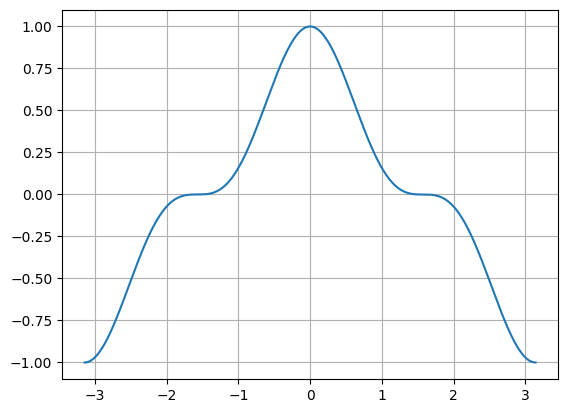

In [99]:
#True value

True_values=np.cos(k*s_0_values)**3


plt.plot(s_0_values,True_values)
plt.grid()
plt.show()



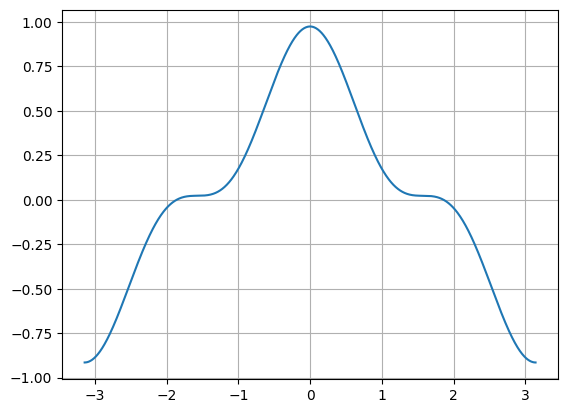

In [100]:
#solution to 1-st order PhiBE

A = np.zeros((2 * M + 1, 2 * M + 1))
b = np.zeros((2 * M + 1, 1))

for traj in trajectories:
    for j in range(m):
        s_j = traj[j]
        mu = ((np.exp(lambda_*delta_t)-1)*s_j) / delta_t
        sigma=( (sig**2/(2*lambda_)) *(np.exp(2*lambda_*delta_t)-1) + (np.exp(lambda_*delta_t)-1)**2 * s_j**2 )/ delta_t
        A += bases(s_j) @ (beta * bases(s_j) - mu * gradient_bases(s_j)-(sigma/2) * gra_gradient_bases(s_j)).T
        b += reward_function(s_j)*bases(s_j)

theta = np.linalg.solve(A, b)

# Compute value function
PhiBE_1st_values = []
for s_0 in s_0_values:
    a = theta.T @ bases(s_0)
    PhiBE_1st_values.append(a.item())

plt.plot(s_0_values,PhiBE_1st_values)
plt.grid()
plt.show()

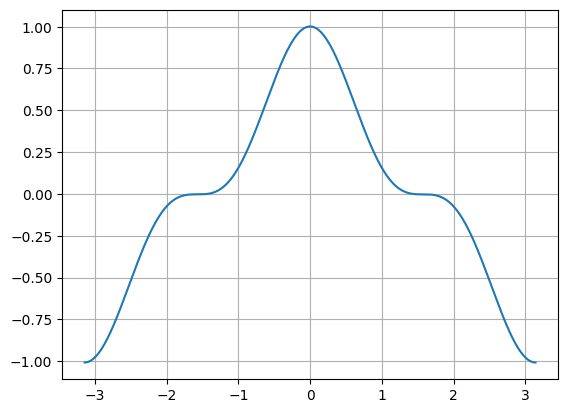

In [101]:
#solution to 2-nd order PhiBE

A11 = np.zeros((2 * M + 1, 2 * M + 1))
b11 = np.zeros((2 * M + 1, 1))

for traj in trajectories:
    for j in range(m):
        s_j = traj[j]
        mu = ((np.exp(lambda_*delta_t)-1)*s_j) / delta_t
        mu = 2*((np.exp(lambda_*delta_t)-1)*s_j) -(1/2)*((np.exp(2*lambda_*delta_t)-1)*s_j)
        mu=mu/ delta_t
        sigma= 2*( (sig**2/(2*lambda_)) *(np.exp(2*lambda_*delta_t)-1) + (np.exp(lambda_*delta_t)-1)**2 * s_j**2 )
        sigma-=(1/2)*( (sig**2/(2*lambda_)) *(np.exp(4*lambda_*delta_t)-1) + (np.exp(2*lambda_*delta_t)-1)**2 * s_j**2 )
        sigma=sigma/ delta_t
        A11 += bases(s_j) @ (beta * bases(s_j) - mu * gradient_bases(s_j)-(sigma/2) * gra_gradient_bases(s_j)).T
        b11 += reward_function(s_j)*bases(s_j)

theta11 = np.linalg.solve(A11, b11)

# Compute value function
PhiBE_2st_values = []
for s_0 in s_0_values:
    a = theta11.T @ bases(s_0)
    PhiBE_2st_values.append(a.item())

plt.plot(s_0_values,PhiBE_2st_values)
plt.grid()
plt.show()

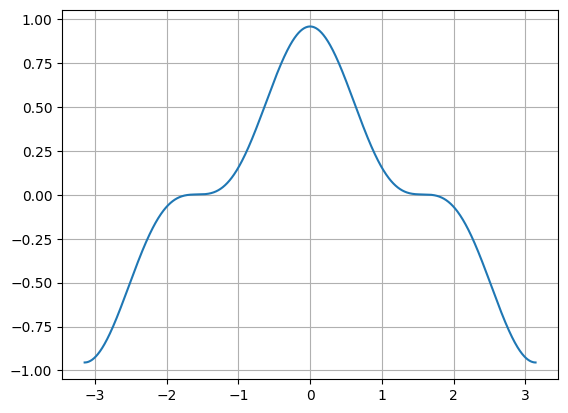

In [102]:
#solution to 1-st order BFF

A2 = np.zeros((2 * M + 1, 2 * M + 1))
b2 = np.zeros((2 * M + 1, 1))

for traj in trajectories:
    for j in range(m):
        s_j = traj[j]
        mu = ((np.exp(lambda_*delta_t)-1)*s_j) / delta_t
        sigma=( (sig**2/(2*lambda_)) *(np.exp(2*lambda_*delta_t)-1) + (1-np.exp(lambda_*delta_t))**3 * s_j**2 )/  delta_t
        A2 += bases(s_j) @ (beta * bases(s_j) - mu * gradient_bases(s_j)-(sigma/2) * gra_gradient_bases(s_j)).T
        b2 += reward_function(s_j)*bases(s_j)

theta2 = np.linalg.solve(A2, b2)

# Compute value function
BFF_1st_values = []
for s_0 in s_0_values:
    a = theta2.T @ bases(s_0)
    BFF_1st_values.append(a.item())

plt.plot(s_0_values,BFF_1st_values)
plt.grid()
plt.show()

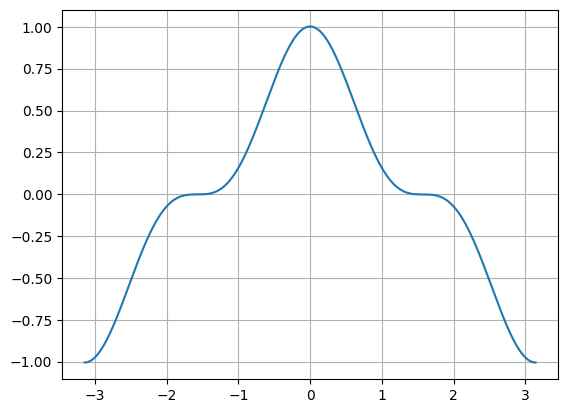

In [103]:
#solution to 2-nd order BFF

A21 = np.zeros((2 * M + 1, 2 * M + 1))
b21 = np.zeros((2 * M + 1, 1))

for traj in trajectories:
    for j in range(m):
        s_j = traj[j]
        mu = 2*((np.exp(lambda_*delta_t)-1)*s_j) -(1/2)*((np.exp(2*lambda_*delta_t)-1)*s_j)
        mu=mu/ delta_t
        sigma= 2*( (sig**2/(2*lambda_)) *(np.exp(2*lambda_*delta_t)-1) + (1-np.exp(lambda_*delta_t))**3 * s_j**2 )
        sigma-=(1/2)*( (sig**2/(2*lambda_)) *(np.exp(4*lambda_*delta_t)-1) + (np.exp(2*lambda_*delta_t)-1)**2 * s_j**2 )
        sigma-=(1/2) * s_j**2 * (1-np.exp(2*lambda_*delta_t))*(np.exp(lambda_*delta_t)+np.exp(3*lambda_*delta_t)-np.exp(2*lambda_*delta_t)-1)
        sigma=sigma/ delta_t
        A21 += bases(s_j) @ (beta * bases(s_j) - mu * gradient_bases(s_j)-(sigma/2) * gra_gradient_bases(s_j)).T
        b21 += reward_function(s_j)*bases(s_j)

theta21 = np.linalg.solve(A21, b21)

# Compute value function
BFF_2nd_values = []
for s_0 in s_0_values:
    a = theta21.T @ bases(s_0)
    BFF_2nd_values.append(a.item())

plt.plot(s_0_values,BFF_2nd_values)
plt.grid()
plt.show()

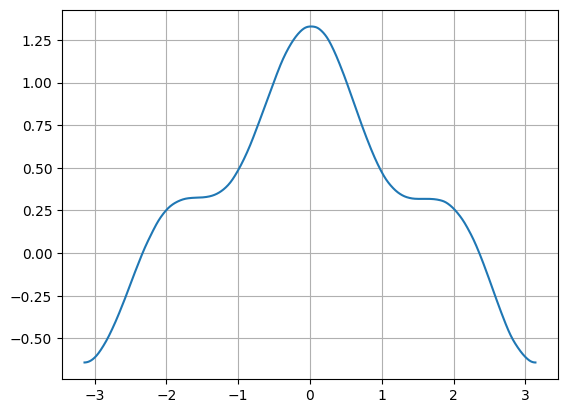

In [104]:
# Algorithm 2 for 1-st order PhiBE
A3 = np.zeros((2 * M + 1, 2 * M + 1))
b3 = np.zeros((2 * M + 1, 1))


for traj in trajectories:
    for j in range(m):
        s_j = traj[j]
        mu=(traj[j+1]-traj[j])/delta_t
        sigma=(traj[j+1]-traj[j])**2
        sigma=sigma/delta_t
        
        A3 +=  bases(s_j) @ (beta * bases(s_j) - mu * gradient_bases(s_j) - (sigma/2)  * gra_gradient_bases(s_j)).T
        b3 +=  reward_function(s_j) * bases(s_j)

theta3 = np.linalg.solve(A3, b3)

# Compute value function
Algorithm_PhiBE_1st_values = []
for s_0 in s_0_values:
    V = theta3.T @ bases(s_0)
    Algorithm_PhiBE_1st_values.append(V.item())


plt.plot(s_0_values, Algorithm_PhiBE_1st_values)
plt.grid()
plt.show()

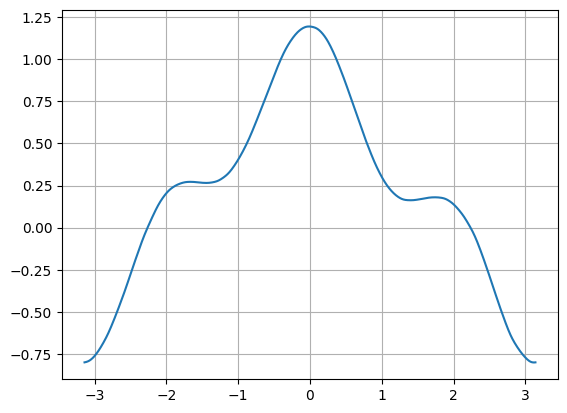

In [105]:
# Algorithm 2 for 1-st order BFF
A4 = np.zeros((2 * M + 1, 2 * M + 1))
b4 = np.zeros((2 * M + 1, 1))


for traj in trajectories:
    for j in range(m):
        s_j = traj[j]
        mu=(traj[j+1]-traj[j])/delta_t
        sigma=(traj[j+1]-traj[j])**2-(traj[j+2]-traj[j+1])*(traj[j+1]-traj[j])
        sigma=sigma/delta_t
        
        A4 +=  bases(s_j) @ (beta * bases(s_j) - mu * gradient_bases(s_j) - (sigma/2)  * gra_gradient_bases(s_j)).T
        b4 +=  reward_function(s_j) * bases(s_j)

theta4 = np.linalg.solve(A4, b4)

# Compute value function
Algorithm_BFF_1st_values = []
for s_0 in s_0_values:
    V = theta4.T @ bases(s_0)
    Algorithm_BFF_1st_values.append(V.item())


plt.plot(s_0_values, Algorithm_BFF_1st_values)
plt.grid()
plt.show()

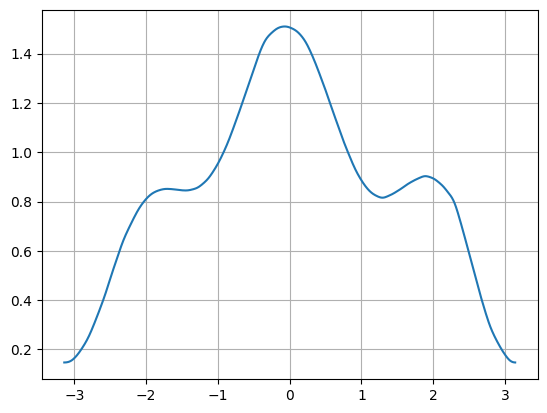

In [106]:
# Algorithm 2 for 2nd order BFF
A41 = np.zeros((2 * M + 1, 2 * M + 1))
b41 = np.zeros((2 * M + 1, 1))


for traj in trajectories:
    for j in range(m):
        s_j = traj[j]
        mu=(2*(traj[j+1]-traj[j])-(1/2)*(traj[j+2]-traj[j]))/delta_t
        sigma=2*(traj[j+1]-traj[j])**2-(1/2)*(traj[j+2]-traj[j])**2
        sigma-=2*(traj[j+2]-traj[j+1])*(traj[j+1]-traj[j])-(1/2)*(traj[j+1]+traj[j+3]-traj[j+2]-traj[j])*(traj[j+2]-traj[j])
        sigma=sigma/delta_t
        
        A41 +=  bases(s_j) @ (beta * bases(s_j) - mu * gradient_bases(s_j) - (sigma/2)  * gra_gradient_bases(s_j)).T
        b41 +=  reward_function(s_j) * bases(s_j)

theta41 = np.linalg.solve(A41, b41)

# Compute value function
Algorithm_BFF_2nd_values = []
for s_0 in s_0_values:
    V = theta41.T @ bases(s_0)
    Algorithm_BFF_2nd_values.append(V.item())


plt.plot(s_0_values, Algorithm_BFF_2nd_values)
plt.grid()
plt.show()

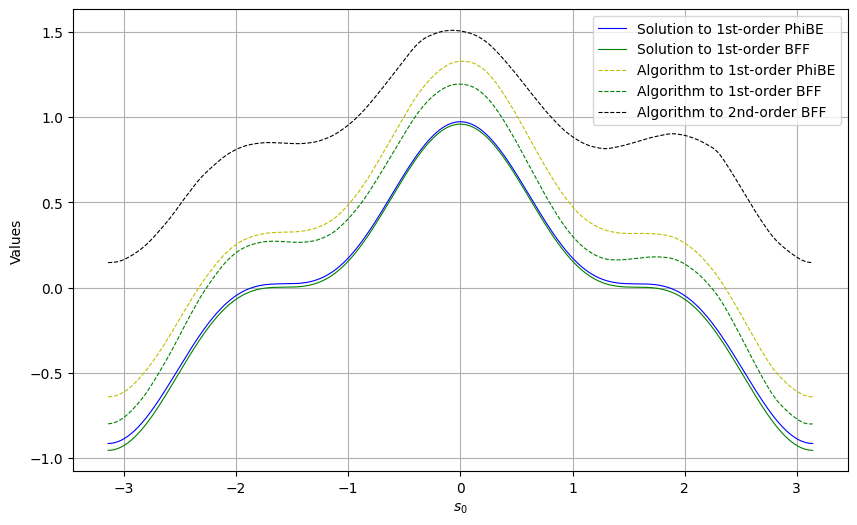

In [107]:
#plot together
plt.figure(figsize=(10, 6))

#plt.plot(s_0_values, True_values, 'r-', label='Exact value function',linewidth=0.8)  # 红色实线
plt.plot(s_0_values, PhiBE_1st_values, 'b-', label='Solution to 1st-order PhiBE',linewidth=0.8)  # 蓝色实线
plt.plot(s_0_values, BFF_1st_values, 'g-', label='Solution to 1st-order BFF',linewidth=0.8)  # 绿色实线
plt.plot(s_0_values, Algorithm_PhiBE_1st_values, 'y--', label='Algorithm to 1st-order PhiBE',linewidth=0.8)  
plt.plot(s_0_values, Algorithm_BFF_1st_values, 'g--', label='Algorithm to 1st-order BFF',linewidth=0.8)  
plt.plot(s_0_values, Algorithm_BFF_2nd_values, 'k--', label='Algorithm to 2nd-order BFF',linewidth=0.8)  

plt.xlabel('$s_0$')
plt.ylabel('Values')


plt.legend()
plt.grid(True)
plt.show()